## **15 주택 가격 예측 모델 - 선형회귀**

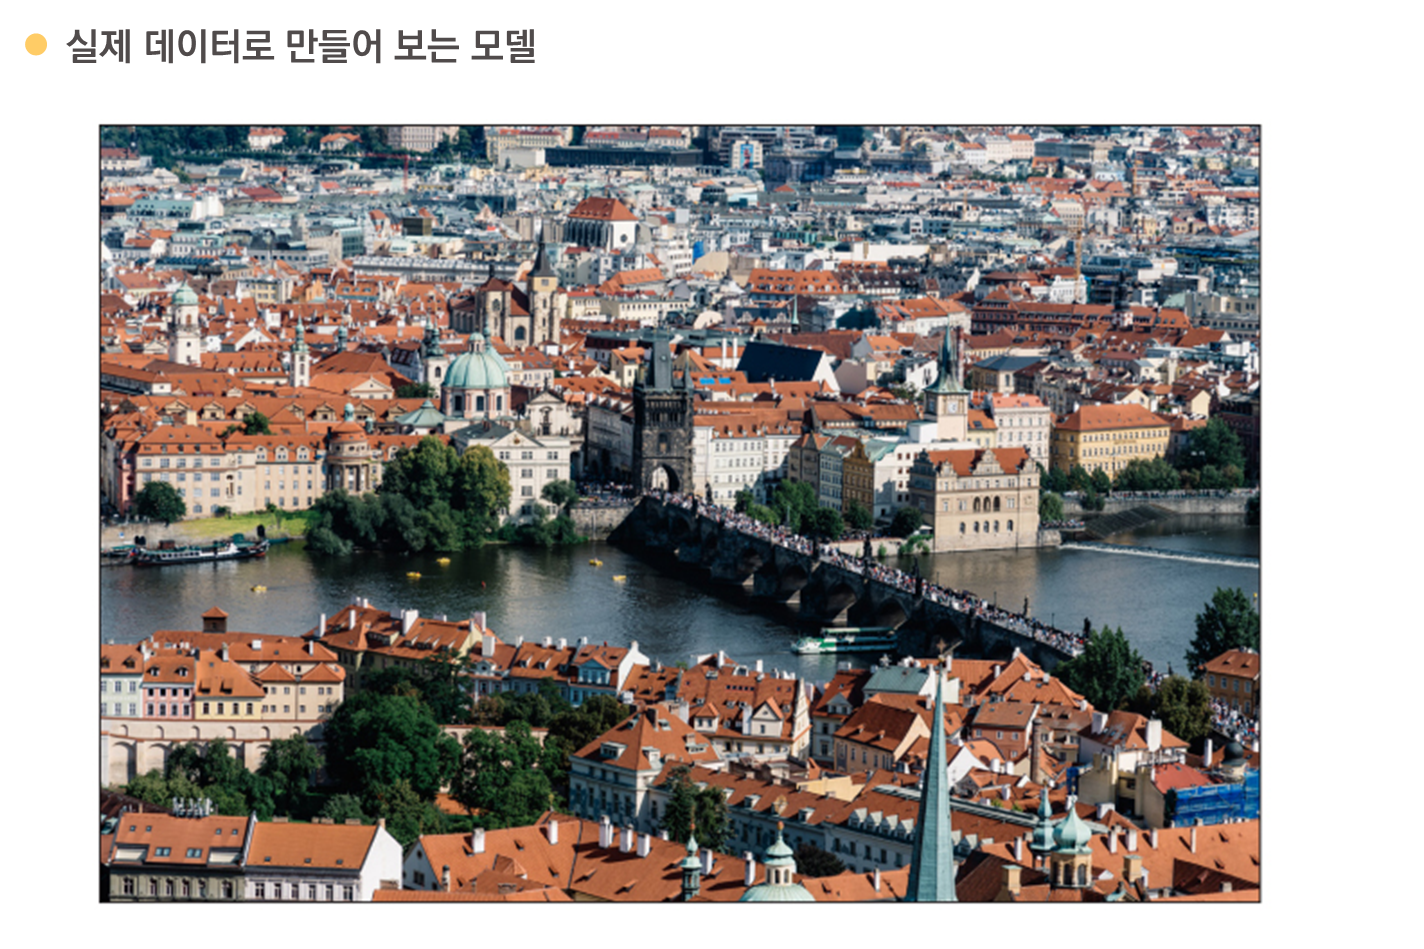

* 지금까지 한 실습은 참 또는 거짓을 맞히거나 여러 개의 보기 중 하나를 예측하는 **분류 (Classification)** 문제
* 이번에는 **수치를 예측하는 문제 (Regression:회귀)**
* 준비된 데이터는 아이오와주 에임스 지역에서 2006년부터 2010년까지 거래된 실제 부동산 판매 기록
* 주거 유형, 차고, 자재 및 환경에 관한 **80개의 서로 다른 속성** 을 이용해 집의 가격을 예측해 볼 예정
* 오랜 시간 사람이 일일이 기록하다 보니 빠진 부분도 많고, 집에 따라 어떤 항목은 범위에서 너무 벗어나 있기도 하며, 또 가격과는 관계가 없는 정보가 포함되어 있기도 함
* 실제 현장에서 만나게 되는 이런 류의 데이터를 어떻게 다루어야 하는지 이 장에서 학습해 보자


* 데이터 출처 : kaggle https://www.kaggle.com/datasets/prevek18/ames-housing-dataset

### 1. 데이터 파악하기

* 데이터 읽기

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

#데이터를 불러 옵니다.
df = pd.read_csv("data/house_train.csv")
df

* 데이터 유형 파악

In [ ]:
df.dtypes

* 기술 통계 분석

In [ ]:
df.describe()  # 숫자 타입 데이터만 나옴

### 2. 결측치, 카테고리 변수 처리하기

* 앞 장에서 다루었던 데이터와 차이점은 아직 전처리가 끝나지 않은 상태의 데이터라 측정 값이 없는 결측치가 있다는 것
* 결측치가 있는지 알아보는 함수는 isnull() 
* 결측치가 모두 몇 개인지 세어 가장 많은 것부터 순서대로 나열한 후 처음 20개만 출력하는 코드는 다음과 같음



In [ ]:
# 결측치 많은 순으로 조회
df.isnull().sum().sort_values(ascending=False).head(20)

#### **전처리** : 카테고리 변수 처리하기

* 판다스의 get_dummies() 함수를 이용해 카테고리형 변수를 0과 1로 이루어진 변수로 바꾸어 줌


* get_dummies()에 대해 알아보기

In [ ]:
pd.get_dummies(df.MSZoning).astype('i')  # Series일 때는 컬럼명으로
# pd.get_dummies(df.MSZoning)  # Series일 때는 컬럼명으로

In [ ]:
# MSZoning을 데이터프레임으로-> get_dummies()
# 데이터프레임에 get_dummies()를 하면 컬럼명_클래스명 으로 만들어짐

pd.get_dummies(df[['MSZoning']])

In [ ]:
## 카테고리형 변수를 One-hot Encoding!
df_onehot = pd.get_dummies(df)
# df_onehot.to_csv('../data/ames_onehot.csv')
df_onehot

#### 결측치 처리 : 평균값으로 채우기

* 결측치를 채워 줌
* 결측치를 채워 주는 함수는 판다스의 fillna() 
* 괄호 안에 df.mean()을 넣어 주면 평균값으로 채워 줌
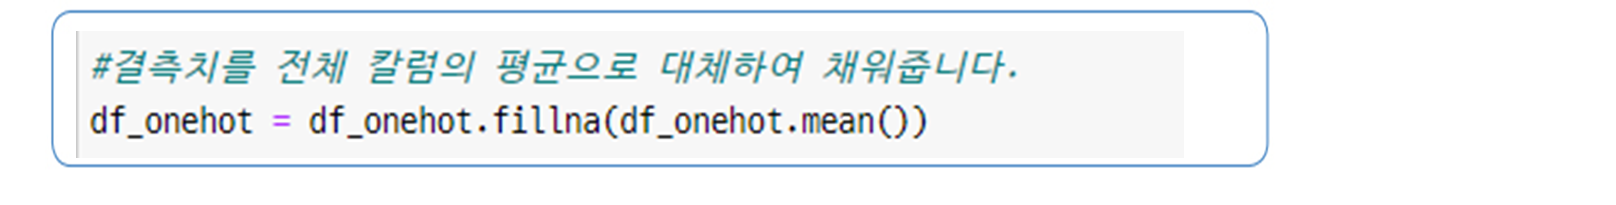

* 특정한 값으로 대체하려면 `fillna()` 함수의 괄호 안에 해당 값을 적으면 됨
* 예를 들어 결측치를 모두 0으로 바꾸려면 `fillna(0)`이 됨
* `dropna()`를 사용하면 결측치가 있는 속성을 제거
* 이때 `dropna(how='any')`는 결측치가 하나라도 있으면 삭제하라는 의미이고, `dropna(how='all')`은 모든 값이 결측치일 때 삭제하라는 의미



In [ ]:
df_onehot = df_onehot.fillna(df_onehot.mean())
df_onehot

In [ ]:
# 결측치 많은 순으로 조회
df_onehot.isnull().sum().sort_values(ascending=False).head(20)

#### 3. 속성별 관련도 추출

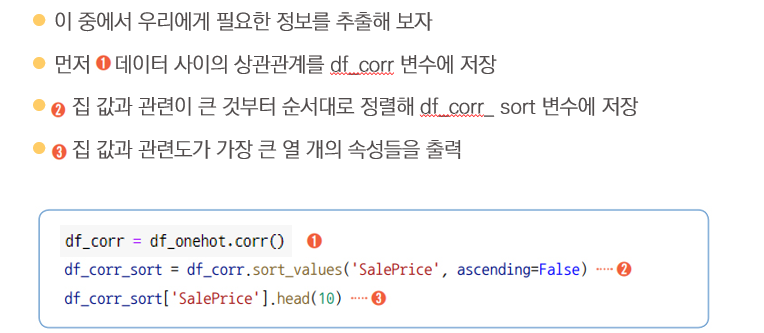

In [ ]:
df_onehot.corr()

* 속성별 관련도 추출하기

In [ ]:
# 집 값 'SalePrice'와 관련도가 가장 큰 순서로 상관도 데이터 만들기
df_corr_sort = df_onehot.corr().sort_values('SalePrice', ascending=False)['SalePrice']
df_corr_sort[:10]

In [ ]:
# 집값과 관련도가 높은 속성 이름 추출
cols = df_corr_sort[:6].keys()
cols

In [ ]:
# 집값과 관련도가 가장 높은 속성들을 추출해서 상관도 그래프 그리기
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df_onehot[cols])
plt.show()

### 4. 주택가격 예측 모델

* 이제 앞서 구한 중요 속성을 이용해 학습셋과 테스트셋을 만들어 보자
* 집 값을 y로, 나머지 열을 X_train_pre로 저장한 후 전체의 80%를 학습셋으로, 20%를 테스트셋으로 지정


In [ ]:
cols

In [ ]:
#집 값을 제외한 나머지 열을 저장합니다. 
cols_train = ['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF']
X_train_pre = df_onehot[cols_train]
X_train_pre

In [ ]:
#집 값을 저장합니다.
y = df_onehot['SalePrice'].values
y

In [ ]:
#전체의 80%를 학습셋으로, 20%를 테스트셋으로 지정합니다.
X_train, X_test, y_train, y_test = train_test_split(X_train_pre, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

* 모델 설계

In [ ]:
#모델의 구조를 설정합니다.
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1))
model.summary()

* 모델 Compile - optimizer, loss 함수 설정

In [ ]:
#모델을 실행합니다.
model.compile(optimizer ='adam', loss = 'mean_squared_error')
# model.compile(optimizer ='adam', loss = 'mse')


* 콜백 함수 정의

In [ ]:
# 20회 이상 결과가 향상되지 않으면 자동으로 중단되게끔 합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

# 모델의 이름을 정합니다.
modelpath="../data/model/house.keras"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

* 모델 학습 : validation_split, 콜백 함수, epochs 등 지정

In [ ]:
#실행 관련 설정을 하는 부분입니다. 전체의 20%를 검증셋으로 설정합니다. 
history = model.fit(X_train, y_train, validation_split=0.25, epochs=2000, verbose=0,
                    batch_size=32, callbacks=[early_stopping_callback, checkpointer])

* 학습 과정 시각화

In [ ]:
history.history.keys()

In [ ]:
import pandas as pd
df_history = pd.DataFrame(history.history)
df_history

In [ ]:
df_history.plot()

* 주택 가격 예측해 보기
    학습 결과를 시각화하기 위해 예측 값과 실제 값, 실행 번호가 들어갈 빈 리스트를 만들고 25개의 샘플로부터 얻은 결과를 채워 넣겠음


In [ ]:
# 예측 값과 실제 값, 실행 번호가 들어갈 빈 리스트를 만듭니다.
real_prices =[]
pred_prices = []
X_num = []

# 25개의 샘플을 뽑아 실제 값, 예측 값을 출력해 봅니다. 
n_iter = 0
Y_prediction = model.predict(X_test).flatten()
for i in range(25):
    real = y_test[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.2f}, 예상가격: {:.2f}".format(real, prediction))
    real_prices.append(real)
    pred_prices.append(prediction)
    n_iter = n_iter + 1
    X_num.append(n_iter)

In [ ]:
#그래프를 통해 샘플로 뽑은 25개의 값을 비교해 봅니다.

plt.plot(X_num, pred_prices, label='predicted price')
plt.plot(X_num, real_prices, label='real price')
plt.legend()
plt.show()

In [ ]:
## 막대 그래프로 데이터 비교 그리기
import numpy as np
import matplotlib.pyplot as plt

# 막대 너비 설정
bar_width = 0.4

# X_num을 배열로 변환하고 간격을 넓힘
X_num = np.arange(len(pred_prices)) * 1.5  # 간격을 기존보다 벌림

plt.figure(figsize=(12, 5))
plt.bar(X_num - bar_width/2, pred_prices, width=bar_width, alpha=0.7, label='Predicted Price')
plt.bar(X_num + bar_width/2, real_prices, width=bar_width, alpha=0.7, label='Real Price')

plt.xticks(X_num, labels=[str(i) for i in range(len(X_num))])  # X축 눈금 설정
plt.legend()
plt.xlabel("Index")
plt.ylabel("Price")
plt.title("Comparison of Predicted and Real Prices with Wider Gaps")
plt.show()


### 실제 가격과 예상가격을 scatter plot으로 찍어보자

In [ ]:
Y_prediction = model.predict(X_train_pre).flatten()
plt.scatter(y[:1000], Y_prediction[:1000], alpha=0.3)
plt.plot([y[:1000].min(), y[:1000].max()], [y[:1000].min(), y[:1000].max()], c="r")

In [ ]:
## SalePrice를 제외한 5개 컬럼을 X 데이터로, SalePrice 컬럼은 y데이터로 설정
X_train_pre = df_onehot[cols[1:]]
y = df_onehot['SalePrice'].values
X_train_pre

In [ ]:
y

In [ ]:
# 모델의 구조 설정
model = Sequential()
model.add(Dense(10, input_dim=5, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1))     #################??? Linear Regression문제!!! -> activation 없이(항등함수)
model.summary()

In [ ]:
# 최적화함수(optimizer), loss function 설정
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 저장 파일 지정
modelpath = '../data/Ames_house.hdf5'

# 자동 중단 callback (val_loss로 모니터)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

# 모델 자동 저장 (val_loss가 개선되는 것만)
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss',
                                         verbose=1, save_best_only=True)

# 학습 실행! - 25%를 validation set로 설정
history = model.fit(X_train_pre, y, validation_split=0.25, epochs=2000, 
                    batch_size=32, callbacks=[early_stopping_callback, checkpointer])

In [ ]:
history.history.keys()

In [ ]:
df_history = pd.DataFrame(history.history)
df_history.plot()

In [ ]:
X_train_pre[:10], y[:10]

In [ ]:
## 모델로... 가격 추정...
N = 100
model.predict(X_train_pre[:N]).flatten()  # shape를 펼쳐서 y와 같게!

In [ ]:
y_predicted = model.predict(X_train_pre[:N]).flatten()
plt.plot(range(N), y[:N], label='real price')
plt.plot(range(N), y_predicted, label='predicted price')
plt.legend()
plt.show()

In [ ]:
# 예측 값과 실제 값, 실행 번호가 들어갈 빈 리스트를 만듭니다.
real_prices =[]
pred_prices = []
X_num = []

# 25개의 샘플을 뽑아 실제 값, 예측 값을 출력해 봅니다. 
n_iter = 0
Y_prediction = model.predict(X_train_pre).flatten()
for i in range(25):
    real = y[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.2f}, 예상가격: {:.2f}".format(real, prediction))
    real_prices.append(real)
    pred_prices.append(prediction)
    n_iter = n_iter + 1
    X_num.append(n_iter)